In [1]:
# data access
import earthaccess

# custom tool functions
import importlib
import tools
import makeL3_scripts
importlib.reload(tools)
importlib.reload(makeL3_scripts)
from tools import *
from makeL3_scripts import makeL3, path_to_gridded_ds

# data manipulation
import numpy as np
import xarray as xr
import cf_xarray  # noqa: F401
import rasterio
import rioxarray as rio

from rasterio.enums import Resampling
from tqdm import tqdm

# plotting
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
loc = "SO"
res = 1.0
strres = {1.0:"1deg", 0.1:"0p1deg"}[res]

xlim = {"SEP":[20,3e3], "SO":[5,50]}
ylim = {"SEP":[1,3e2], "SO":[5,50]}

In [3]:
fileL3 = "/home/jovyan/shared-public/mucloud-hackweek2025-data/harpL3."+loc+"."+strres+".nc"

In [4]:
ds = xr.open_dataset(fileL3)
ds

<xarray.Dataset> Size: 6MB
Dimensions:                                           (time: 174, latitude: 11,
                                                       longitude: 51)
Coordinates:
  * time                                              (time) datetime64[ns] 1kB ...
  * latitude                                          (latitude) float64 88B ...
  * longitude                                         (longitude) float64 408B ...
Data variables: (12/14)
    cloud_bow_droplet_effective_radius                (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_effective_variance              (time, latitude, longitude) float32 390kB ...
    cloud_bow_droplet_number_concentration_adiabatic  (time, latitude, longitude) float32 390kB ...
    cloud_bow_liquid_water_path                       (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_0         (time, latitude, longitude) float32 390kB ...
    cloud_rft_droplet_effective_radius_mode_1         (time, latitude, longitude) float32 390kB ...
    ...                                                ...
    cloud_rft_mode_fraction_0                         (time, latitude, longitude) float32 390kB ...
    cloud_rft_mode_fraction_1                         (time, latitude, longitude) float32 390kB ...
    cloud_top_altitude                                (time, latitude, longitude) float32 390kB ...
    cloud_top_temperature                             (time, latitude, longitude) float32 390kB ...
    cloud_top_pressure                                (time, latitude, longitude) float32 390kB ...
    cloud_liquid_index_mask                           (time, latitude, longitude) float64 781kB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.10171989 -0.1...
    att_roll_start_end_degrees:                             [-0.01183303 -0.1...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-20.5951   -14.6...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

In [5]:
ds_filter = ds.where(ds.cloud_liquid_index_mask > 0.5)

In [6]:
from xarray.groupers import BinGrouper

nd_bins = np.geomspace(1,5000,num=50)
lwp_bins = np.geomspace(1,2000,num=40)

ds_binned = ds_filter.groupby(
    cloud_bow_droplet_number_concentration_adiabatic=BinGrouper(bins=nd_bins),
    cloud_bow_liquid_water_path=BinGrouper(bins=lwp_bins),
).mean()
bincounts = ds_filter.groupby(
    cloud_bow_droplet_number_concentration_adiabatic=BinGrouper(bins=nd_bins),
    cloud_bow_liquid_water_path=BinGrouper(bins=lwp_bins),
).count()

ds_binned["counts"] = bincounts.cloud_bow_liquid_water_path
ds_binned.counts.attrs = {
    'long_name': 'counts per bin',
    'units': '',
    'valid_min': np.float32(0.0),
    'valid_max': np.inf,
    'grid_mapping': 'spatial_ref'}

ds_binned

<xarray.Dataset> Size: 131kB
Dimensions:                                                (
                                                            cloud_bow_droplet_number_concentration_adiabatic_bins: 49,
                                                            cloud_bow_liquid_water_path_bins: 39)
Coordinates:
  * cloud_bow_droplet_number_concentration_adiabatic_bins  (cloud_bow_droplet_number_concentration_adiabatic_bins) interval[float64, right] 784B ...
  * cloud_bow_liquid_water_path_bins                       (cloud_bow_liquid_water_path_bins) interval[float64, right] 624B ...
Data variables: (12/15)
    cloud_bow_droplet_effective_radius                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_bow_droplet_effective_variance                   (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_bow_droplet_number_concentration_adiabatic       (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_bow_liquid_water_path                            (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_rft_droplet_effective_radius_mode_0              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_rft_droplet_effective_radius_mode_1              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    ...                                                     ...
    cloud_rft_mode_fraction_1                              (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_top_altitude                                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_top_temperature                                  (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_top_pressure                                     (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float32 8kB ...
    cloud_liquid_index_mask                                (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float64 15kB ...
    counts                                                 (cloud_bow_droplet_number_concentration_adiabatic_bins, cloud_bow_liquid_water_path_bins) float64 15kB ...
Attributes: (12/110)
    Conventions:                                            CF-1.10
    acquisition_scheme:                                     4
    att_pitch_start_end_degrees:                            [-0.10171989 -0.1...
    att_roll_start_end_degrees:                             [-0.01183303 -0.1...
    att_time_offset:                                        0.0
    att_yaw_start_end_degrees:                              [-20.5951   -14.6...
    ...                                                     ...
    cloud_rft_lut_file_name:                                /sdps/sdpsoper/Sc...
    cloud_rft_scatt_angle_required_min:                     135.83791174582538
    cloud_rft_scatt_angle_required_max:                     150.0
    cloud_rft_scatt_angle_to_use_lo:                        135.83791174582538
    cloud_rft_scatt_angle_to_use_hi:                        165.0
    cloud_rft_decomposition_size_correlation_required_min:  0.95

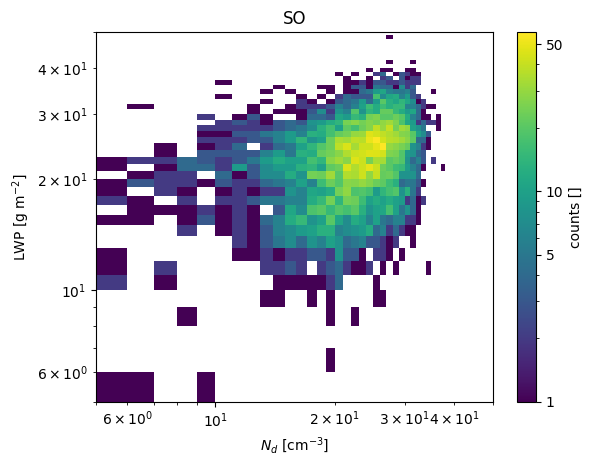

In [23]:
var = "counts"
c = plt.pcolormesh(ds_binned[var],norm=LogNorm())
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(c, label=var+" ["+ds_binned[var].attrs["units"]+"]")
cbar.set_ticks([1,5,10,50])
cbar.set_ticklabels(["1","5","10","50"])
plt.show()

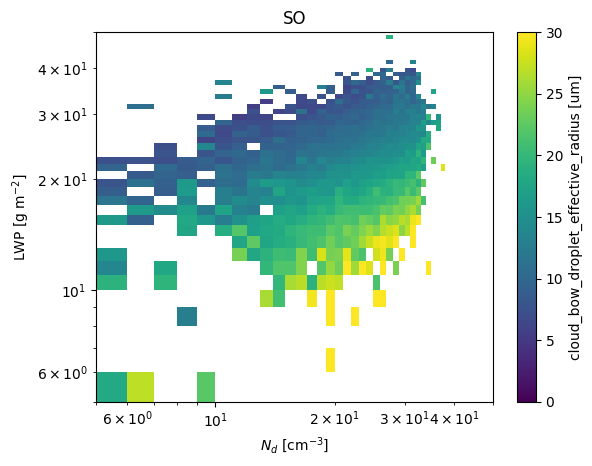

In [24]:
var = "cloud_bow_droplet_effective_radius"
c = plt.pcolormesh(ds_binned[var],vmin=0,vmax=30)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(c, label=var+" ["+ds_binned[var].attrs["units"]+"]")
plt.show()

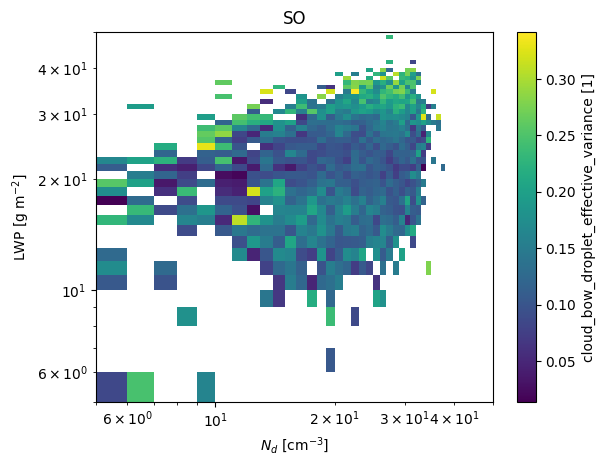

In [25]:
var = "cloud_bow_droplet_effective_variance"
c = plt.pcolormesh(ds_binned[var])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(c, label=var+" ["+ds_binned[var].attrs["units"]+"]")
plt.show()

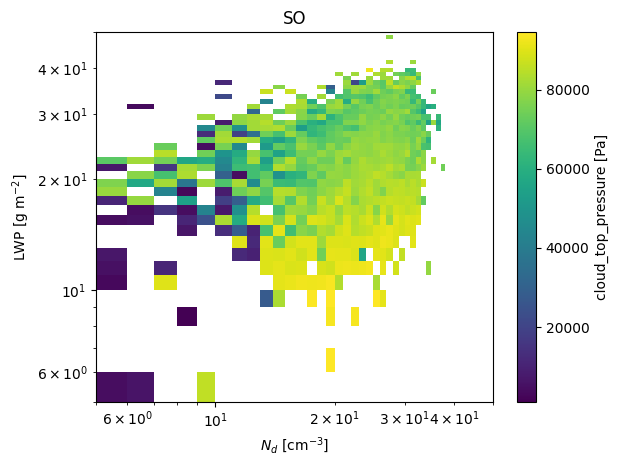

In [26]:
var = "cloud_top_pressure"
c = plt.pcolormesh(ds_binned[var])
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$N_d$ [cm$^{-3}$]")
plt.ylabel("LWP [g m$^{-2}$]")
plt.xlim(xlim[loc])
plt.ylim(ylim[loc])
plt.title(loc)
cbar = plt.colorbar(c, label=var+" ["+ds_binned[var].attrs["units"]+"]")
plt.show()